# Aligning full coronal sections of adult mouse brain from MERFISH and Xenium

In this notebook, we align two single cell resolution spatial transcriptomics datasets of full coronal sections of the adult mouse brain from approximately the same locations assayed by MERFISH and Xenium.

We will use `STalign` to achieve this alignment. We will first load the relevant code libraries.

In [2]:
# import dependencies
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch

# import STalign from upper directory
# skip next 2 lines if STalign.py in same folder as notebook
#import sys
#sys.path.append("../../") 
import STalign

# make plots bigger
plt.rcParams["figure.figsize"] = (12,10)

We have already downloaded single cell spatial transcriptomics datasets and placed the files in a folder called `merfish_data` and `xenium_data`.

We can read in the cell information for the first dataset using `pandas` as `pd`.

In [51]:
# Single cell data 1
# read in data
fname = '../../merfish_data/datasets_mouse_brain_map_BrainReceptorShowcase_Slice2_Replicate3_cell_metadata_S2R3.csv.gz'
df1 = pd.read_csv(fname)
print(df1.head())

                                Unnamed: 0  fov       volume    center_x  \
0  158338042824236264719696604356349910479   33   532.778772  617.916619   
1  260594727341160372355976405428092853003   33  1004.430016  596.808018   
2  307643940700812339199503248604719950662   33  1267.183208  578.880018   
3   30863303465976316429997331474071348973   33  1403.401822  572.616017   
4  313162718584097621688679244357302162401   33   507.949497  608.364018   

      center_y       min_x       max_x        min_y        max_y  
0  2666.520010  614.725219  621.108019  2657.545209  2675.494810  
1  2763.450012  589.669218  603.946818  2757.013212  2769.886812  
2  2748.978012  570.877217  586.882818  2740.489211  2757.466812  
3  2766.690012  564.937217  580.294818  2756.581212  2776.798812  
4  2687.418010  603.061218  613.666818  2682.493210  2692.342810  


For alignment with `STalign`, we only need the cell centroid information. So we can pull out this information. We can further visualize the cell centroids to get a sense of the variation in cell density that we will be relying on for our alignment by plotting using `matplotlib.pyplot` as `plt`. 

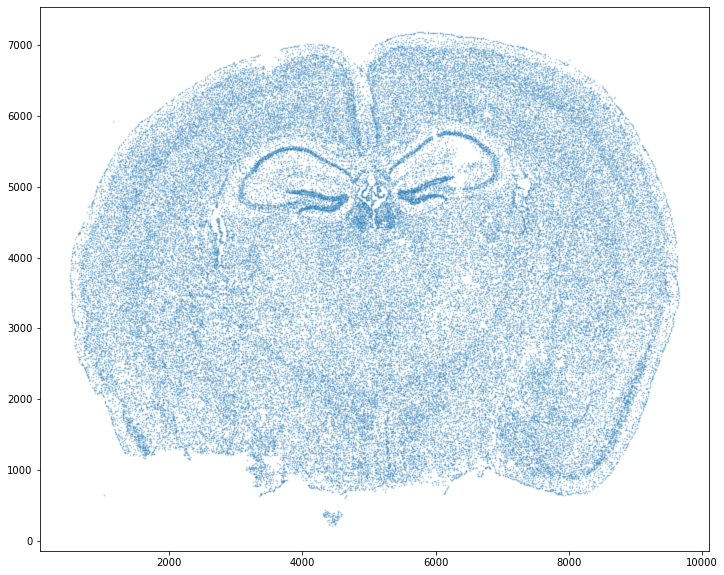

In [52]:
# get cell centroid coordinates
xI = np.array(df1['center_x'])
yI = np.array(df1['center_y'])

# plot
fig,ax = plt.subplots()
ax.scatter(xI,yI,s=1,alpha=0.2)

We will first use `STalign` to rasterize the single cell centroid positions into an image. Assuming the single-cell centroid coordinates are in microns, we will perform this rasterization at a 30 micron resolution. We can visualize the resulting rasterized image.

Note that points are plotting with the origin at bottom left while images are typically plotted with origin at top left so we've used `invert_yaxis()` to invert the yaxis for visualization consistency. 

0 of 85958
10000 of 85958
20000 of 85958
30000 of 85958
40000 of 85958
50000 of 85958
60000 of 85958
70000 of 85958
80000 of 85958
85957 of 85958


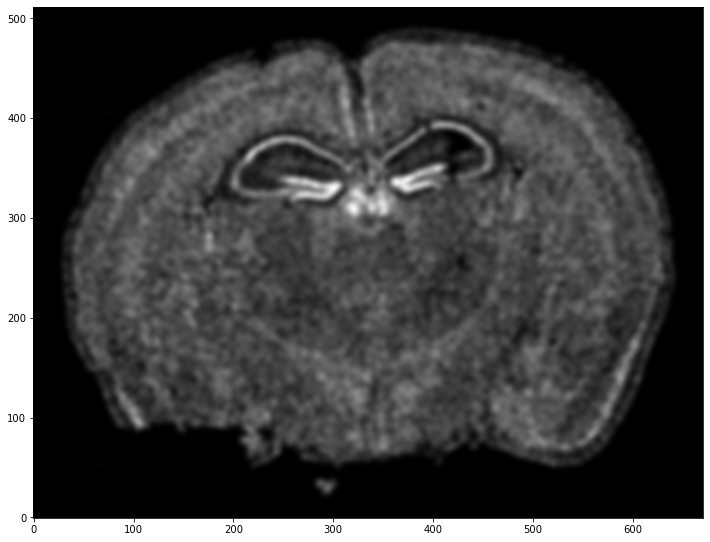

In [73]:
# rasterize at 30um resolution (assuming positions are in um units) and plot
XI,YI,I,fig = STalign.rasterize(xI,yI,dx=15,blur=1.5)

# plot
ax = fig.axes[0]
ax.invert_yaxis()

Now, we can repeat this for the cell information from the second dataset.

0 of 162033
10000 of 162033
20000 of 162033
30000 of 162033
40000 of 162033
50000 of 162033
60000 of 162033
70000 of 162033
80000 of 162033
90000 of 162033
100000 of 162033
110000 of 162033
120000 of 162033
130000 of 162033
140000 of 162033
150000 of 162033
160000 of 162033
162032 of 162033


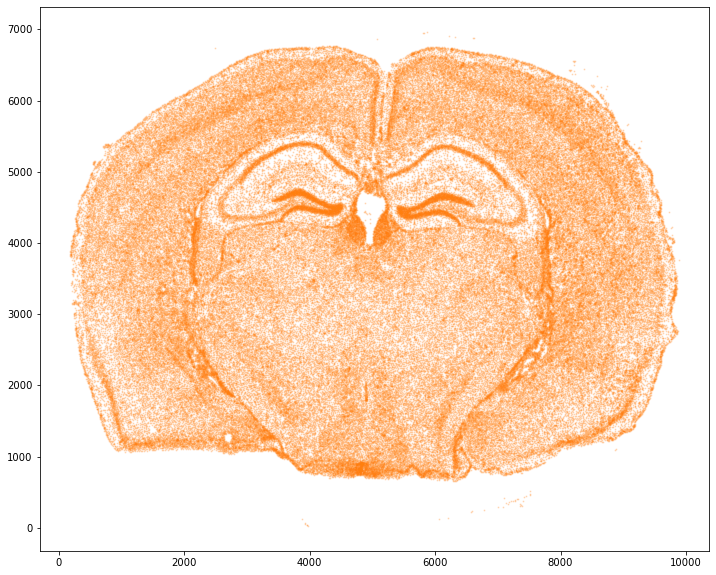

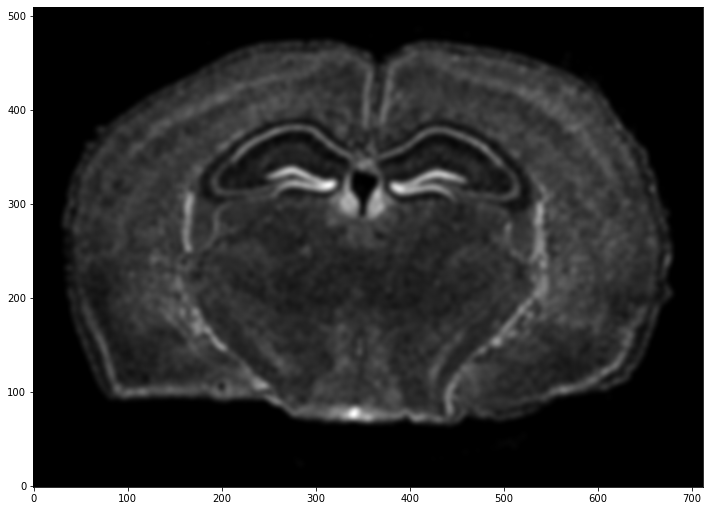

In [74]:
# Single cell data 2
# read in data
fname = '../../xenium_data/Xenium_V1_FF_Mouse_Brain_MultiSection_1_cells.csv.gz'
df2 = pd.read_csv(fname)

# get cell centroids
xJ = np.array(df2['x_centroid'])
yJ = np.array(df2['y_centroid'])

# plot
fig,ax = plt.subplots()
ax.scatter(xJ,yJ,s=1,alpha=0.2,c='#ff7f0e')

# rasterize and plot
XJ,YJ,J,fig = STalign.rasterize(xJ,yJ,dx=15, blur=1.5)
ax = fig.axes[0]
ax.invert_yaxis()

Note that plotting the cell centroid positions from both datasets shows that non-linear local alignment is needed.

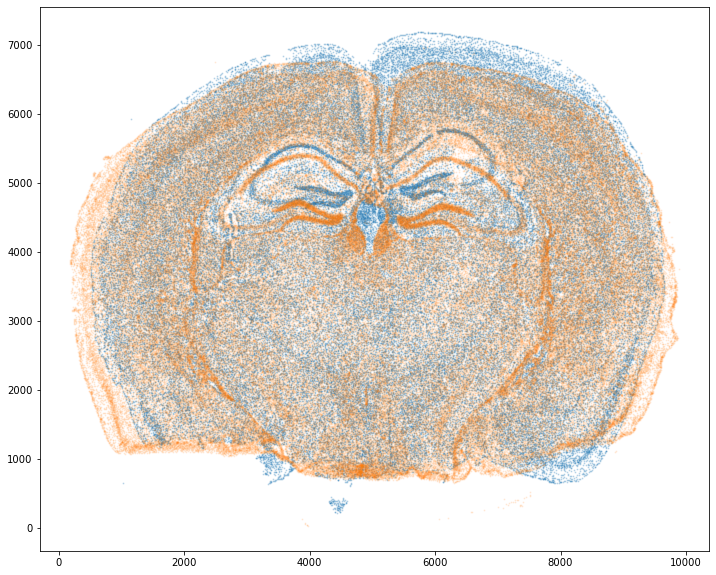

In [75]:
# plot
fig,ax = plt.subplots()
ax.scatter(xI,yI,s=1,alpha=0.2)
ax.scatter(xJ,yJ,s=1,alpha=0.1)

We can also plot the rasterized images next to each other.

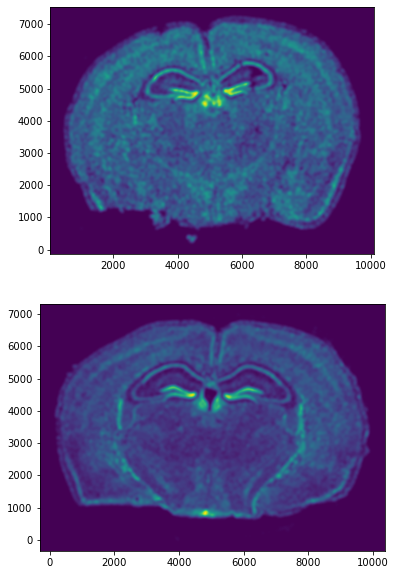

In [76]:
# get extent of images
extentI = STalign.extent_from_x((YI,XI))
extentJ = STalign.extent_from_x((YJ,XJ))

# plot rasterized images
fig,ax = plt.subplots(2,1)
ax[0].imshow((I.transpose(1,2,0).squeeze()), extent=extentI) # just want 201x276 matrix
ax[1].imshow((J.transpose(1,2,0).squeeze()), extent=extentJ) # just want 201x276 matrix
ax[0].invert_yaxis()
ax[1].invert_yaxis()

Now we will perform our alignment. There are many parameters that can be tuned for performing this alignment. If we don't specify parameters, defaults will be used. 

In [ ]:
%%time

# run LDDMM
# specify device (default device for STalign.LDDMM is cpu)
if torch.cuda.is_available():
    device = 'cuda:0'
else:
    device = 'cpu'

# keep all other parameters default
params = {
          'niter': 10000,
          'device':device,
          'epV': 50
          }

Ifoo = np.vstack((I, I, I)) # make RGB instead of greyscale
Jfoo = np.vstack((J, J, J)) # make RGB instead of greyscale
out = STalign.LDDMM([YI,XI],Ifoo,[YJ,XJ],Jfoo,**params)

In [ ]:
# get necessary output variables
A = out['A']
v = out['v']
xv = out['xv']

Plots generated throughout the alignment can be used to give you a sense of whether the parameter choices are appropriate and whether your alignment is converging on a solution.

We can also evaluate the resulting alignment by applying the transformation to visualize how our source and target images were deformed to achieve the alignment. 

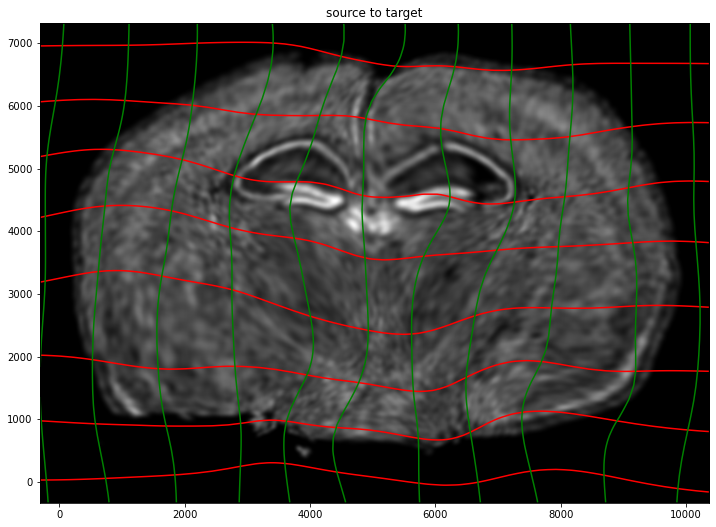

In [84]:
# apply transform
phii = STalign.build_transform(xv,v,A,XJ=[YJ,XJ],direction='b')
phiI = STalign.transform_image_atlas_to_target(xv,v,A,[YI,XI],Ifoo,[YJ,XJ])

# plot with grids
fig,ax = plt.subplots()
levels = np.arange(-100000,100000,1000)
ax.contour(XJ,YJ,phii[...,0],colors='r',linestyles='-',levels=levels)
ax.contour(XJ,YJ,phii[...,1],colors='g',linestyles='-',levels=levels)
ax.set_aspect('equal')
ax.set_title('source to target')
ax.imshow(phiI.permute(1,2,0)/torch.max(phiI),extent=extentJ)
ax.invert_yaxis()

Note that because of our use of LDDMM, the resulting transformation is invertible.

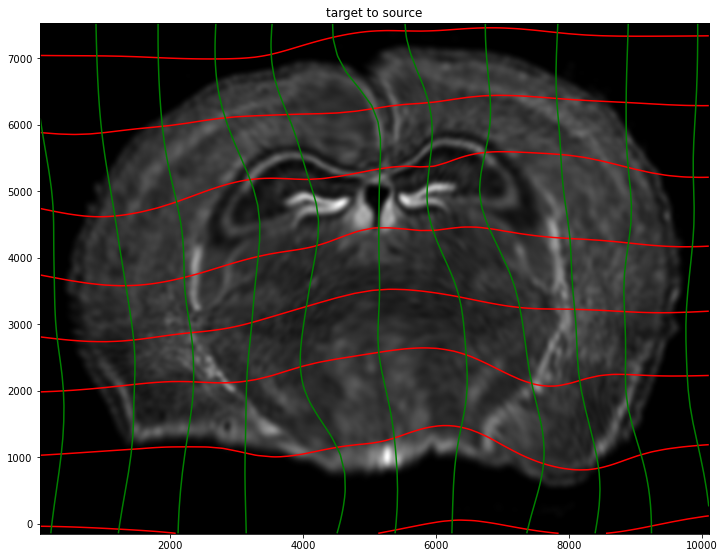

In [85]:
# transform is invertible
phi = STalign.build_transform(xv,v,A,XJ=[YI,XI],direction='f')
phiiJ = STalign.transform_image_target_to_atlas(xv,v,A,[YJ,XJ],Jfoo,[YI,XI])

# plot with grids
fig,ax = plt.subplots()
levels = np.arange(-100000,100000,1000)
ax.contour(XI,YI,phi[...,0],colors='r',linestyles='-',levels=levels)
ax.contour(XI,YI,phi[...,1],colors='g',linestyles='-',levels=levels)
ax.set_aspect('equal')
ax.set_title('target to source')
ax.imshow(phiiJ.permute(1,2,0)/torch.max(phiiJ),extent=extentI)
ax.invert_yaxis()

Finally, we can apply our transform to the original sets of single cell centroid positions to achieve their new aligned positions.

In [86]:
# apply transform to original points
tpointsJ = STalign.transform_points_target_to_atlas(xv,v,A, np.stack([yJ, xJ], 1))

# just original points for visualizing later
tpointsI = np.stack([xI, yI]) 

And we can visualize the results.

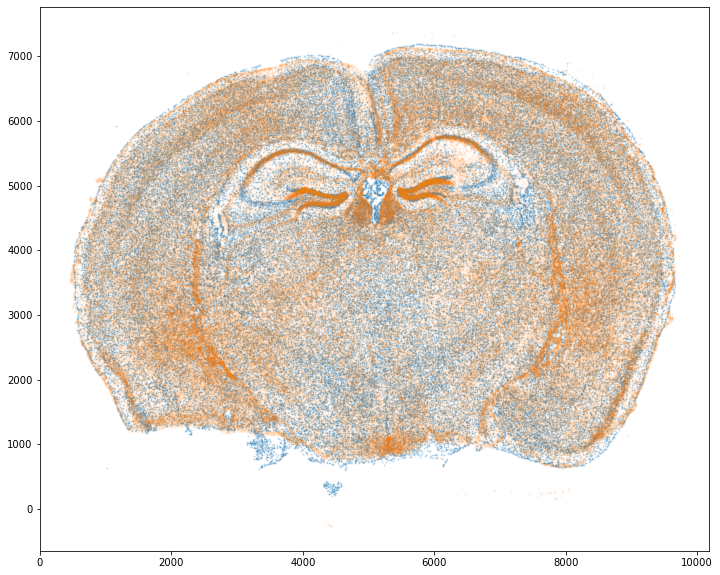

In [87]:
# plot results
fig,ax = plt.subplots()
ax.scatter(tpointsI[0,:],tpointsI[1,:],s=1,alpha=0.2) 
ax.scatter(tpointsJ[:,1],tpointsJ[:,0],s=1,alpha=0.1) # also needs to plot as y,x not x,y

We can also plot the transformed dataset by itself.

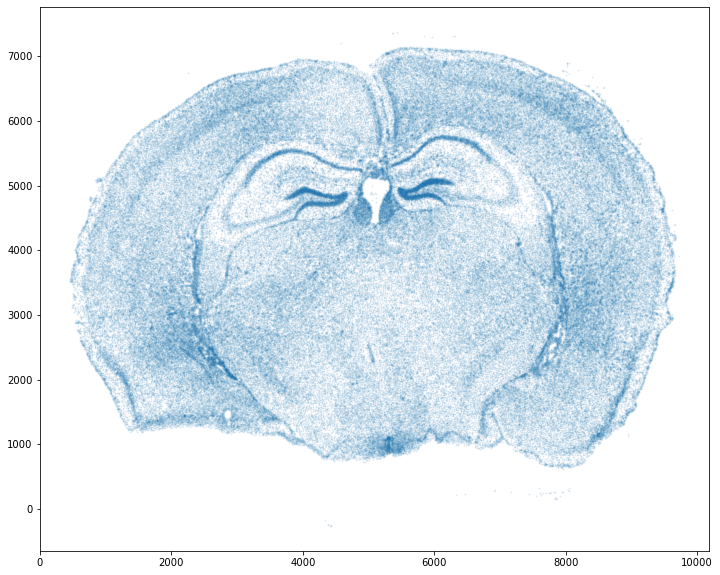

In [90]:
fig,ax = plt.subplots()
ax.scatter(tpointsJ[:,1],tpointsJ[:,0],s=1,alpha=0.1) # also needs to plot as y,x not x,y

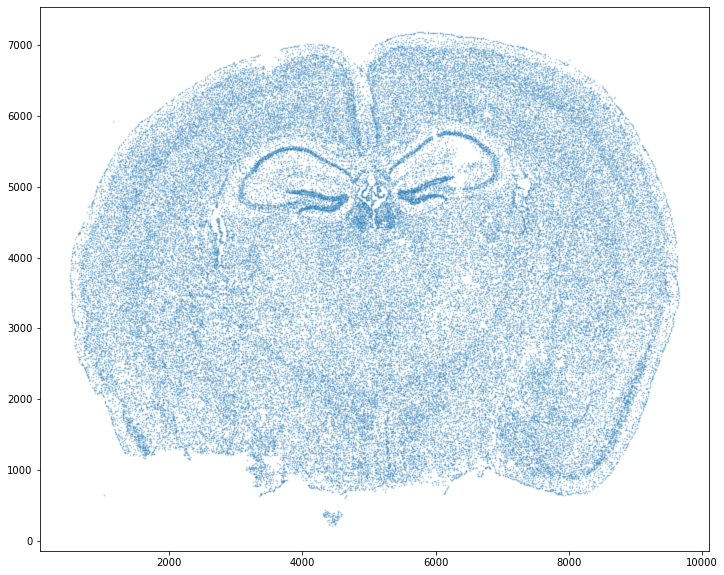